# **Installation**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.cm as cm
from scipy.stats import norm
import matplotlib.pyplot as plt

from textwrap import wrap
from matplotlib.cm import get_cmap

from bokeh.palettes import viridis
viridis_palette = viridis(256)
winter_palette = cm.get_cmap('winter', 256)

# **Data Import**

In [2]:
df = pd.read_csv("strokes.csv")

file_path = 'hole-ttc-2011.txt'
hole_df = pd.read_csv(file_path, delimiter=';')
hole_df.rename(columns={'Player #': 'player_id','Hole #': 'hole', 'Round #':'round'}, inplace=True)
temp_hole_df = hole_df
temp_hole_df = temp_hole_df[['player_id', 'hole', 'round', 'Time Hole Finished', 'Actual Yard']]

df = pd.merge(df, temp_hole_df, on=['player_id', 'hole', 'round'], how='inner')
df = df.drop_duplicates()

# **'Strokes to Hole Out'**

Most important feature of this project, allowing us to predict Expected Strokes

In [3]:
df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] + df['num_of_strokes'] # df['num_of_strokes'] was 1

# **Outliers**

In [4]:
z_scores = stats.zscore(df['strokes_to_hole_out'])
outliers = df[(z_scores < -3) | (z_scores > 3)]
print(f'{len(outliers)} Z Scores outliers')

Q1 = df['strokes_to_hole_out'].quantile(0.25)
Q3 = df['strokes_to_hole_out'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['strokes_to_hole_out'] < (Q1 - 1.5 * IQR)) | (df['strokes_to_hole_out'] > (Q3 + 1.5 * IQR))]
outliers
print(f'{len(outliers)} Interquartile Range outliers')


6 Z Scores outliers
6 Interquartile Range outliers


# **Discard Incorrect 'Strokes to Hole Out'**

In [5]:
#eventually Impute discarded values and sanity check 'Hole' Lies have a 'strokes_to_hole_out' value above 0

df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['bad_strokes_to_hole_out_value_flag'] = (df['strokes_to_hole_out'] <= 0)

#looks like .iloc 1939 and 5731 are the only messed up holes so thats a W!
selected_rows = df[df['bad_strokes_to_hole_out_value_flag']]


# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
df = df[df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
df = df.drop(columns=['_merge']).reset_index(drop=True)

# (df['strokes_to_hole_out'] == 0).sum()

# **Inches to Yards**

In [6]:
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_from_edge'] = df['dist_from_edge']/36

df['dist_from_center'] = df['dist_from_center']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36

# **'Strokes to Hole Out' vs 'Distance to Pin'**

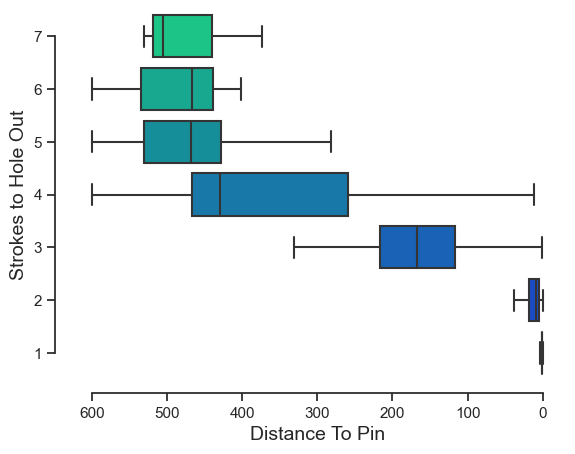

In [7]:
# [Whisker](https://docs.bokeh.org/en/latest/docs/examples/basic/annotations/whisker.html)

# [Ridgeplot](https://docs.bokeh.org/en/latest/docs/examples/topics/categorical/ridgeplot.html)

# Set Seaborn style
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a horizontal nested boxplot to show bills by day and time
ax = sns.boxplot(y="strokes_to_hole_out", x="distance_to_pin",
            #hue="lie_location", 
            palette='winter',
            data=df,
            orient="h",
            showfliers=False)
sns.despine(offset=10, trim=True)
ax.invert_yaxis()
ax.invert_xaxis()

# Set labels
plt.xlabel('Distance To Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Show the plot
plt.show()

# **'Strokes to Hole Out' vs 'Lie Location'**

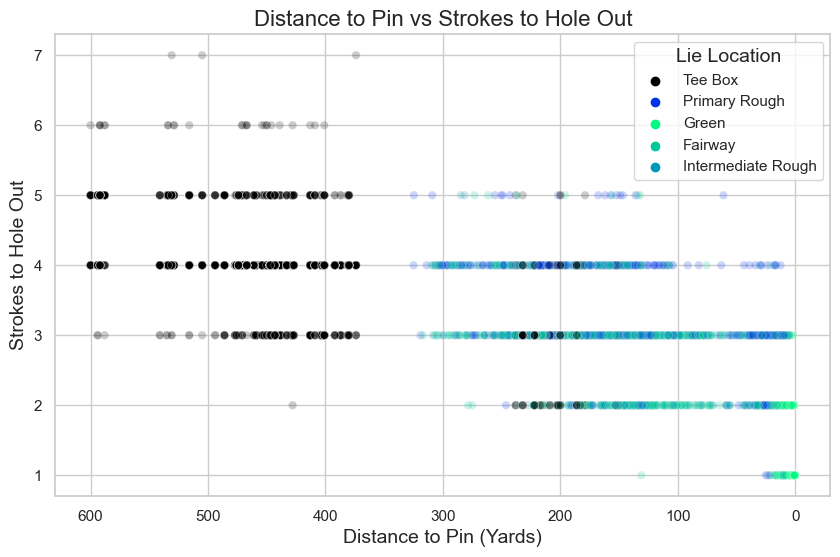

In [8]:
# Set Seaborn style
sns.set(style='whitegrid')

#ignore high level lies for viz
temp_df = df[df['from_location_scorer'] != 'Other']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Native Area']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Unknown']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Water']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Fringe']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Fairway Bunker']
temp_df = temp_df[temp_df['from_location_scorer'] != 'Green Side Bunker']

# Define the indices for the colors
Pri_Rough_index = 50  # Adjust as needed
Intermediate_Rough_index = 150  # Adjust as needed
fairway_index = 200  # Adjust as needed
green_index = 250  # Adjust as needed

# Extract colors from the palette at the specified indices
Pri_Rough_index_hash = winter_palette(Pri_Rough_index)
Intermediate_Rough_index_hash = winter_palette(Intermediate_Rough_index)
fairway_index_hash = winter_palette(fairway_index)
green_index_hash = winter_palette(green_index)

custom_colors = {
    'Tee Box': 'black', 
    'Primary Rough': Pri_Rough_index_hash,
    'Intermediate Rough':Intermediate_Rough_index_hash, 
    'Fairway': fairway_index_hash,
    'Green': green_index_hash,}

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
ax = scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out',alpha=0.2, hue='from_location_scorer', palette=custom_colors, data=temp_df)
ax.invert_xaxis()

# Set plot title and labels
plt.title('Distance to Pin vs Strokes to Hole Out', fontsize=16)
plt.xlabel('Distance to Pin (Yards)', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper right')

# Show the plot
plt.show()

# Feature Engineer High Level Detailed Lie Locations
df['to_location_scorer'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',df['to_location_scorer'])
# Feature Engineer Low Level Lie Locations for later

df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# Shift all values in the 'column_name' down by one row
df['next_lie_location'] =  df['lie_location']

df['lie_location'] = df['lie_location'].shift(1)

df['lie_location'] =    np.where(df['shot'] == 1, 'Tee',df['lie_location'])

# **Putting Features**

In [9]:
# distance to pin - distance to edge
df['pin_minus_edge'] = df['distance_to_pin'] - df['dist_from_edge']

# - distance to pin / distance to edge
df['pin_over_edge'] = (df['distance_to_pin']) /(df['dist_from_edge']) 

df['first_putt'] = df['first_putt'].fillna('No')

# **Non Putting Features**

In [10]:
# Short Sided Index
df['SSI'] = (df['distance_to_pin']-df['dist_from_edge'])/df['distance_to_pin']

# Center Sided Index
df['CSI'] = (df['distance_to_pin']-abs(df['dist_from_center']))/df['distance_to_pin']

# New 'Hole Completeness' feature
df['hole_completeness'] = 1 - df['distance_to_pin']/df['Actual Yard']

df['ISS'] = df['distance_to_pin']/(df['distance_to_pin']+abs(df['dist_from_edge']))

df['ISC'] = df['distance_to_pin']/(df['distance_to_pin']+abs(df['dist_from_center']))


# **Binning**

## **Non Putting Distance Binning**

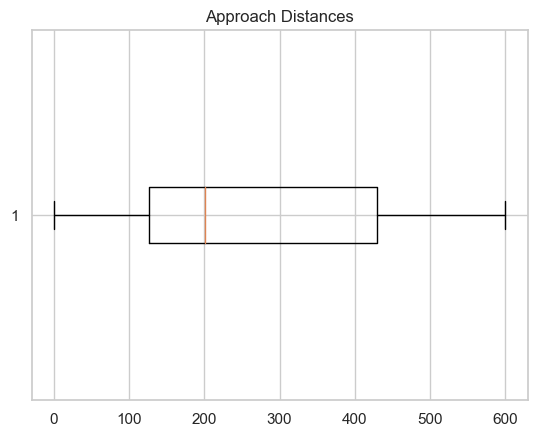

In [11]:
non_green_df = df[df['lie_location'] != 'Green']
plt.title('Approach Distances')
B = plt.boxplot(non_green_df['distance_to_pin'], vert=False)
plt.show()

whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]

bin1 = (median_values[0][0] + whisker_values[0][0])/2
bin2 = (median_values[0][0] + whisker_values[1][0])/2

bins =    [0,       bin1,      bin2,601]
labels = [f'0-{bin1}', f'{bin1}-{bin2}', f'{bin2}-601']

df['distance_bins'] = pd.cut(df['distance_to_pin'], bins=bins, labels=labels, right=False)
# print(df['distance_bins'].isna().sum())
df['distance_bins'] = df['distance_bins'].cat.add_categories([''])
df['distance_bins'].fillna('', inplace=True)
# print(df['distance_bins'].isna().sum())

# **General Center Binning**

Could reduce to putting non putting if strat goes bad

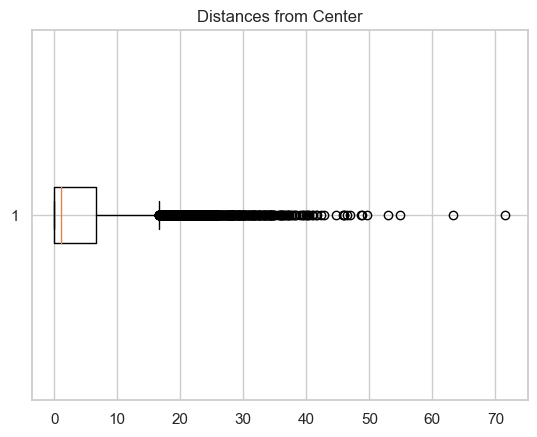

In [12]:
# non_green_df = df[df['lie_location'] == 'Green']
plt.title('Distances from Center')
B = plt.boxplot(df['dist_from_center'], vert=False)
plt.show()

whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]

bin1 = (median_values[0][0] + whisker_values[0][0])/2
bin2 = (median_values[0][0] + whisker_values[1][0])/2

bins =    [0, bin1,      bin2,601]
labels = [f'0-{bin1}',f'{bin1}-{bin2}', f'{bin2}-601']

df['center_distance_bins'] = pd.cut(df['dist_from_center'], bins=bins, labels=labels, right=False)
# print(df['center_distance_bins'].isna().sum())
df['center_distance_bins'] = df['center_distance_bins'].cat.add_categories([''])
df['center_distance_bins'].fillna('', inplace=True)
# print(df['center_distance_bins'].isna().sum())

# **Putting Edge Binning**

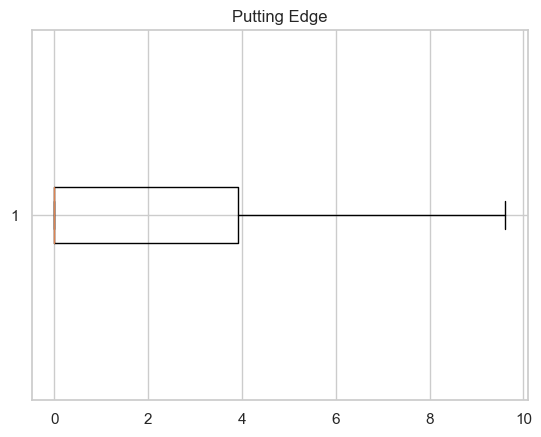

In [13]:
green_df = df[df['lie_location'] == 'Green']
plt.title('Putting Edge')
B = plt.boxplot(green_df['dist_from_edge'], vert=False,showfliers=False)
plt.show()

whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]
bin1 = (median_values[0][0] + whisker_values[0][0])/2
bin2 = (median_values[0][0] + whisker_values[1][0])/2

bins =    [bin1,      bin2,42]
labels = [f'{bin1}-{bin2}', f'{bin2}-42']

df['edge_bins_putting'] = pd.cut(df['dist_from_edge'], bins=bins, labels=labels, right=False,duplicates='drop')
# print(df['distance_bins_putting'].isna().sum())
df['edge_bins_putting'] = df['edge_bins_putting'].cat.add_categories([''])
df['edge_bins_putting'].fillna('', inplace=True)
# print(df['distance_bins_putting'].isna().sum())

# **Putting Distance Binning**

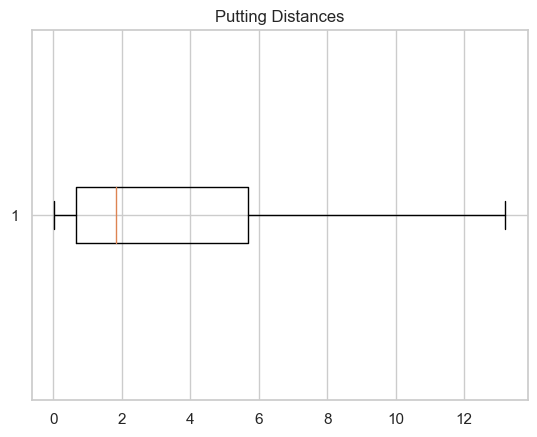

In [14]:
green_df = df[df['lie_location'] == 'Green']
plt.title('Putting Distances')
B = plt.boxplot(green_df['distance_to_pin'], vert=False,showfliers=False)
plt.show()

whisker_values = [whiskers.get_xdata() for whiskers in B['whiskers']]
median_values = [medians.get_xdata() for medians in B['medians']]
bin1 = (median_values[0][0] + whisker_values[0][0])/2
bin2 = (median_values[0][0] + whisker_values[1][0])/2

bins =    [0,       bin1,      bin2,601]
labels = [f'0-{bin1}', f'{bin1}-{bin2}', f'{bin2}-601']

df['distance_bins_putting'] = pd.cut(df['distance_to_pin'], bins=bins, labels=labels, right=False)
# print(df['distance_bins_putting'].isna().sum())
df['distance_bins_putting'] = df['distance_bins_putting'].cat.add_categories([''])
df['distance_bins_putting'].fillna('', inplace=True)
# print(df['distance_bins_putting'].isna().sum())

# **External Data**

In [15]:
#Dog_legs
Dog_legs = {1: 'R',2: 'N', 3: 'N', 4: 'L', 5: 'N', 6: 'R', 7: 'N', 8: 'N', 9: 'N', 10: 'N', 11: 'N', 12: 'N', 13: 'R', 14: 'R', 15: 'N', 16: 'L', 17: 'L', 18: 'L'}
df['dog_legs'] = df['hole'].map(Dog_legs)

#HCP
HCP = {1: 5,2: 17, 3: 13, 4: 11, 5: 3, 6: 9, 7: 1, 8: 7, 9: 15, 10: 8, 11: 18, 12: 12, 13: 4, 14: 10, 15: 16, 16: 2, 17: 14, 18: 6}
df['HCP'] = df['hole'].map(HCP)

# **Saving Feature Engineered Data**

In [16]:
df.to_csv('FE_golf.csv')